In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')

c:\Users\burka\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\_compat.py:154: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()


In [2]:
place_name = "Üniversiteler Mahallesi, Çankaya, Ankara"
# Retrieve the network
graph = ox.graph_from_place(place_name, network_type='drive')

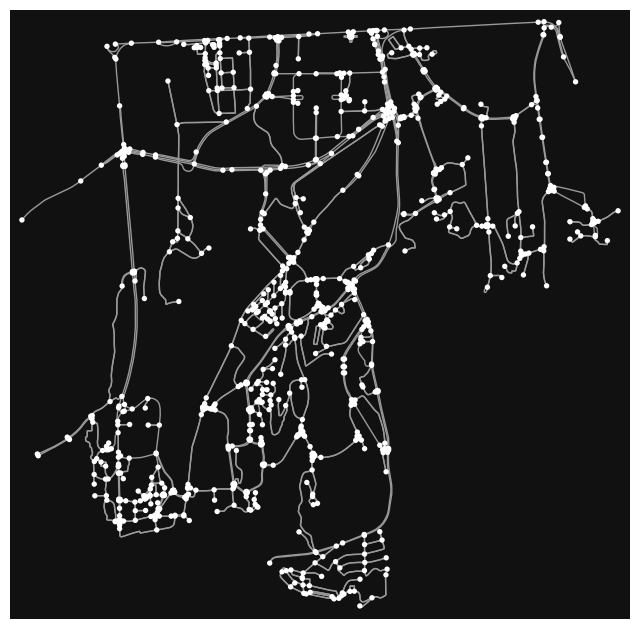

In [3]:
# plot the graph:
fig, ax = ox.plot_graph(graph)

In [4]:
place_polygon = ox.geocode_to_gdf(place_name) # Get the area of interest polygon
place_polygon = place_polygon.to_crs(epsg=32636) # Re-project the polygon to a local projected CRS
place_polygon["geometry"] = place_polygon.buffer(1000) # Buffer a bit
place_polygon = place_polygon.to_crs(epsg=4326) # Re-project the polygon back to WGS84, as required by osmnx


In [5]:
# Retrieve the network
graph = ox.graph_from_polygon(place_polygon["geometry"].values[0], network_type='drive')

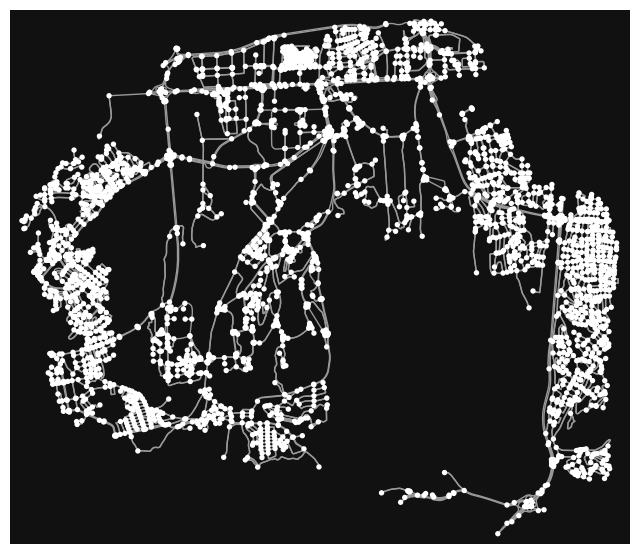

In [6]:
fig, ax = ox.plot_graph(graph)  # plot the graph	    

Tamam artık daha önce belirttiğimiz seyahat modu için sokaklarımız var. Sokak ağının özelliklerine daha yakından bakalım. Bunu yapmanın en kolay yolu dönüştürmektir
Grafiği (düğümler ve kenarlar) GeoDataFrames'e aktarın.

Grafiğin GeoDataFrame'e dönüştürülmesi, önceki derste kullandığımız `graph_to_gdfs()` işleviyle yapılabilir. 'Düğümler' ve 'kenarlar' parametreleriyle, grafikten hem düğümlerin hem de kenarların alınıp alınmayacağını kontrol etmek mümkündür.

In [8]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
edges.columns

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'bridge', 'geometry', 'junction', 'access',
       'tunnel', 'width'],
      dtype='object')

In [10]:
edges.crs # Check the CRS of the edges GeoDataFrame

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Okey, so we have quite many columns in our GeoDataFrame. Most of the columns are fairly self-explanatory but the following table describes all of them.
Most of the attributes come directly from the OpenStreetMap, however, columns `u` and `v` are Networkx specific ids. You can click on the links to get more information about each attribute:


| Column                                                     | Description                 | Data type         |
|------------------------------------------------------------|-----------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)    | Bridge feature              | boolean           |
| geometry                                                   | Geometry of the feature     | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)  | Tag for roads (road type)   | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)      | Number of lanes             | int (or nan)      |
| [lenght](http://wiki.openstreetmap.org/wiki/Key:length)    | Length of feature (meters)  | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)| maximum legal speed limit   | int /list         |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)        | Name of the (street) element| str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)    | One way road                | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)           | Unique ids for the element  | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                              | The first node of edge      | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                              | The last node of edge       | int               |


In [11]:
# Project the data
graph_proj = ox.project_graph(graph)

In [15]:
# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [16]:
print("Coordinate system:", edges_proj.crs)
print("Coordinate system:", nodes_proj.crs)

Coordinate system: +proj=utm +zone=36 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
Coordinate system: +proj=utm +zone=36 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [17]:
CRS(edges_proj.crs).to_epsg()

32636

## Shortest path analysis

In [18]:
# Set place name
placename = "Beytepe Gün Hastanesi"

In [20]:
# Geocode the place name
geocoded_place = ox.geocode_to_gdf(placename)
geocoded_place

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((32.73336 39.86792, 32.73337 39.86785...",39.868142,39.867543,32.733933,32.733361,216474944,way,544163794,39.867832,32.733637,building,hospital,30,0.00001,building,Beytepe Gün Hastanesi,"Beytepe Gün Hastanesi, 1596. Cd., Üniversitele..."


In [21]:
geocoded_place.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
# Re-project into the same CRS as the road network
geocoded_place = geocoded_place.to_crs(CRS(edges_proj.crs))  # cartesian a donduk

In [25]:
geocoded_place.crs  

<Projected CRS: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Wor ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
# Get centroid as shapely point
origin = geocoded_place["geometry"].centroid.values[0]

In [27]:
print(origin)

POINT (477220.3000015202 4413124.292571072)


## AYNI SEYLERI VARIS NOKTASI ICINDE YAPIYORUZ

In [28]:
target_place = "Yükseköğretim Kurulu"
geocoded_place = ox.geocode_to_gdf(target_place)
geocoded_place = geocoded_place.to_crs(CRS(edges_proj.crs))
destination = geocoded_place["geometry"].centroid.values[0]
print(destination)


POINT (479601.6050168251 4414131.373820656)


In [31]:
orig_node_id = ox.distance.nearest_nodes(graph_proj, origin.x, origin.y)
target_node_id = ox.distance.nearest_nodes(graph_proj, destination.x, destination.y)

In [32]:
nodes_proj.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
27046640,4.417642e+06,481547.703853,3,32.784116,39.908662,NaN,POINT (481547.704 4417642.033)
11033172719,4.417634e+06,481349.855476,3,32.781802,39.908588,NaN,POINT (481349.855 4417634.278)
27046645,4.417654e+06,481753.314259,3,32.786522,39.908774,NaN,POINT (481753.314 4417653.969)
393950525,4.417650e+06,481678.403786,3,32.785645,39.908736,NaN,POINT (481678.404 4417649.887)
27046662,4.417453e+06,477660.164643,3,32.738641,39.906869,NaN,POINT (477660.165 4417453.349)


In [33]:
# Retrieve the rows from the nodes GeoDataFrame based on the node id (node id is the index label)
orig_node = nodes_proj.loc[orig_node_id]
target_node = nodes_proj.loc[target_node_id]

In [34]:
orig_node

y                                             4413120.638253
x                                              477183.868024
street_count                                               3
lon                                                 32.73322
lat                                                39.867819
highway                                                  NaN
geometry        POINT (477183.86802443804 4413120.638252617)
Name: 2190683018, dtype: object

In [35]:
target_node

y                                            4414108.623696
x                                             479504.258394
street_count                                              3
lon                                                32.76032
lat                                                39.87678
highway                                                 NaN
geometry        POINT (479504.2583941403 4414108.623696389)
Name: 1830393332, dtype: object

In [36]:
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([orig_node, target_node], geometry='geometry', crs=nodes_proj.crs)
od_nodes.head()

,y,x,street_count,lon,lat,highway,geometry
2190683018,4.413121e+06,477183.868024,3,32.73322,39.867819,NaN,POINT (477183.868 4413120.638)
1830393332,4.414109e+06,479504.258394,3,32.76032,39.876780,NaN,POINT (479504.258 4414108.624)


## Routing

In [37]:
route = nx.shortest_path(G=graph_proj, source=orig_node_id, target=target_node_id, weight='length')
print(route)

[2190683018, 8533662516, 8533662515, 8533672124, 8533672128, 8533662483, 2190728551, 2349163258, 2190728553, 2190728556, 2190728559, 2190672584, 6694304244, 2190672587, 2190728539, 2345117633, 8533672289, 2190728535, 2190728565, 8533672168, 11238075878, 11259631015, 8533672177, 8533672159, 1312329482, 9032600778, 9032600793, 9028350330, 9028350333, 9028350357, 9028350336, 9028433976, 9028433974, 9028433972, 206189569, 206189548, 206189546, 310043096, 1043879537, 206189540, 288238726, 288204402, 2144951652, 2342970965, 2190697077, 2190697095, 2359839297, 493134885, 680392150, 148985787, 2190697113, 2190697085, 7918183291, 2359839294, 1830392905, 1830393332]


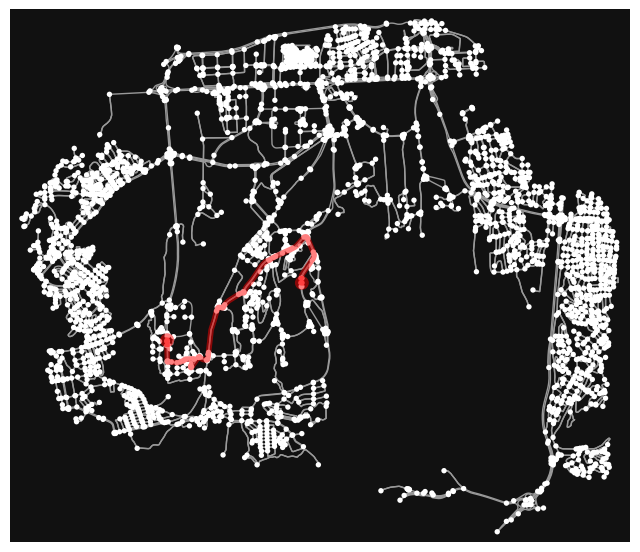

In [38]:
fig, ax = ox.plot_graph_route(graph_proj, route)

## Kayıt fln ısterse harıta ustune devamı (sınavdacıkar) olan dosyada